In [1]:
import torch
from datasets import load_mnist, get_observation_pixels
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

BATCH_SIZE = 100
train_loader, test_loader, val_loader = load_mnist(BATCH_SIZE)

In [2]:
from models import VQVAE
import pytorch_lightning as pl

class VAETrainer(pl.LightningModule):
    def __init__(self):
        super(VAETrainer, self).__init__()
        
        self.model = VQVAE(1, 512, 64)
        
    def forward(self, x, x_cond, y):
        return self.model(x)
    
    def step(self, batch, batch_idx, mode = 'train'):
        x, x_cond, y = batch
        x_hat, quantized, latent, embedding_indices = self(x, x_cond, y)
        loss = self.model.loss(latent, quantized, x_hat, x)
        self.log_dict({f"{mode}_{key}": val.item() for key, val in loss.items()}, sync_dist=True, prog_bar=True)
        return loss['loss']
    
    def decode(self, z):
        return self.model.decode(z)
        
    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, 'train')
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, 'val')
    def test_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, 'test')
    
    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=1e-3)

In [3]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/',
    filename='base-vae-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

logger = TensorBoardLogger('./', version="vq_vae_50")

model = VAETrainer()
trainer = pl.Trainer(accelerator='gpu', devices=[5], max_epochs=50, enable_progress_bar=True, callbacks=[checkpoint_callback], logger=logger)
trainer.fit(model, train_loader, val_loader)
#save
trainer.save_checkpoint('checkpoints/vqvae_50.ckpt')

/Home/siv34/edzak2974/.conda/envs/pytorch_masters/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch_masters/li ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Home/siv34/edzak2974/.conda/envs/pytorch_masters/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch_masters/li ...
  rank_zero_warn(
You are using a CUDA device ('A100-S

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 49: 100%|██████████| 600/600 [00:11<00:00, 51.16it/s, v_num=e_50, train_loss=0.0146, train_recon_loss=0.00218, train_vq_loss=0.0125, train_commitment_loss=0.00997, train_embeddding_loss=0.00997, val_loss=0.0147, val_recon_loss=0.00233, val_vq_loss=0.0124, val_commitment_loss=0.0099, val_embeddding_loss=0.0099]   

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 600/600 [00:11<00:00, 51.15it/s, v_num=e_50, train_loss=0.0146, train_recon_loss=0.00218, train_vq_loss=0.0125, train_commitment_loss=0.00997, train_embeddding_loss=0.00997, val_loss=0.0147, val_recon_loss=0.00233, val_vq_loss=0.0124, val_commitment_loss=0.0099, val_embeddding_loss=0.0099]


quantized.shape =  torch.Size([4900, 64])
torch.Size([100, 1, 28, 28])


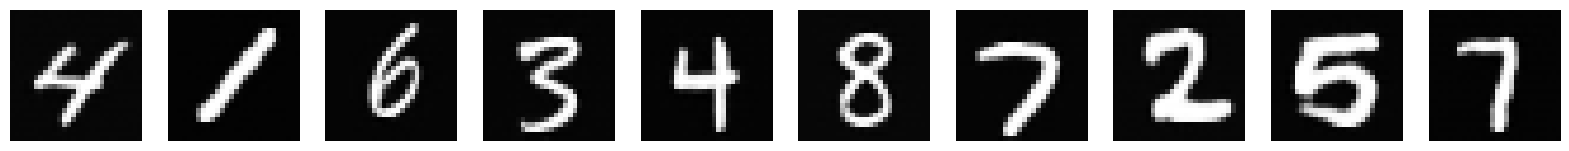

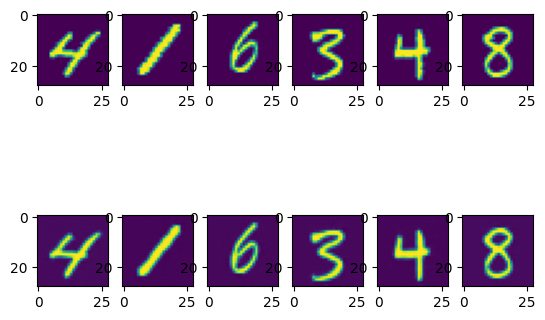

In [5]:
model = VAETrainer.load_from_checkpoint('checkpoints/vqvae_50.ckpt', map_location='cpu')
model.eval()

from plotting import plot_samples_with_reconstruction
# plot some samples and their reconstructions

x, _, _ = next(iter(test_loader))

_, _, _, indices = model.model(x)

res = model.model.reconstruct_from_indices(indices)

print(res.shape)

# plot some of the reconstructions

from matplotlib import pyplot as plt
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(res[i, 0, :, :].detach().numpy(), cmap='gray')
    plt.axis('off')
plt.show()




plot_samples_with_reconstruction(model, next(iter(test_loader)))

In [3]:
from models.autoregresive import PixelCNN
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable


class PixelCNNTrainer(pl.LightningModule):
    def __init__(self, vae, ):
        super(PixelCNNTrainer, self).__init__()
        self.vae = vae
        self.model = PixelCNN(output_channels=512)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)
    
    def step(self, batch, batch_idx, mode = 'train'):
        x, x_cond, y = batch
        x_hat, quantized, latent, embedding_indices= self.vae(x, x_cond, y)
        
        # reshape back embedding indices and detach from graph
        embedding_indices = embedding_indices.reshape(shape=(latent.shape[0], 1, latent.shape[2], latent.shape[3]))
        target = Variable(embedding_indices[:,0,:,:]).long() 

        logits = self(embedding_indices.float())

        loss = self.criterion(logits, target)
        self.log(f"{mode}_loss", loss)
        return loss

        
    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, 'train')
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, 'val')
    def test_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, 'test')
    
    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=1e-3)
    
        

In [4]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/',
    filename='pixelcnn-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

logger = TensorBoardLogger('./', version="pixelcnn-vqvae_50.ckpt")

vae = VAETrainer.load_from_checkpoint('checkpoints/vqvae_50.ckpt', map_location='cpu')

model = PixelCNNTrainer(vae)
trainer = pl.Trainer(accelerator='gpu', devices=[5], max_epochs=50, enable_progress_bar=True, callbacks=[checkpoint_callback], logger=logger)
trainer.fit(model, train_loader, val_loader)
#save
trainer.save_checkpoint('checkpoints/pixel_cnn_vqvae_50.ckpt')

/Home/siv34/edzak2974/.conda/envs/pytorch_masters/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch_masters/li ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Home/siv34/edzak2974/.conda/envs/pytorch_masters/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch_masters/li ...
  rank_zero_warn(
You are using a CUDA device ('A100-S

Epoch 49: 100%|██████████| 600/600 [00:08<00:00, 69.90it/s, v_num=ckpt]    

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 600/600 [00:08<00:00, 69.88it/s, v_num=ckpt]


quantized.shape =  torch.Size([4900, 64])
torch.Size([100, 1, 28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])


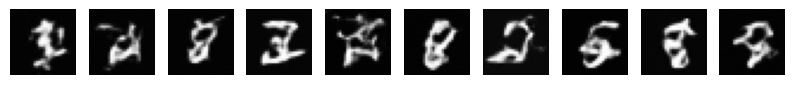

In [6]:
from matplotlib import pyplot as plt

vae = VAETrainer.load_from_checkpoint('checkpoints/vqvae_50.ckpt', map_location='cpu')

model = PixelCNNTrainer.load_from_checkpoint('checkpoints/pixel_cnn_vqvae_50.ckpt', map_location='cpu', vae=vae)

def generate_and_plot(model, count, vae):
	sample = torch.Tensor(count, 1, 7, 7)
	sample.fill_(0)
    #Generating images pixel by pixel
	for i in range(7):
		for j in range(7):
			out = model(sample)
			probs = F.softmax(out[:,:,i,j], dim=-1).data
			sample[:,:,i,j] = torch.multinomial(probs, 1).long()
	# plot the images
	plt.figure(figsize=(10, 10))
	test = sample.view(-1)
	test = test.long()




	x_hat = vae.model.reconstruct_from_indices(test)
	print(x_hat.shape)

	for i in range(10):
		print(x_hat[i,0,:,:].shape)
		plt.subplot(1, 10, i+1)
		plt.imshow(x_hat[i,0,:,:].detach(), cmap='gray')
		plt.axis('off')

generate_and_plot(model, count=100, vae=vae)